# CHE1147H - Feature engineering A#3 

In [1]:
# import required library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 
from itertools import product

### <font color='red'>1.1 Import the data and create the anchor date columns</font> 
##### 1 - 2

In [2]:
# Import the dataset as txn
txn = pd.read_csv("Retail_Data_Transactions.csv")

# identify the number of rows
print ("number of rows:", len(txn))

# Create a new column 'txn_date' from 'trans_date'
txn['txn_date'] = pd.to_datetime(txn["trans_date"])

# drop the column 'trans_date'
del txn['trans_date']

number of rows: 125000


##### 3. Identify the min() and max() of column 'txn_date'.

In [3]:
print ("min date:", min(txn['txn_date']))
print ("max date:", max(txn['txn_date']))

min date: 2011-05-16 00:00:00
max date: 2015-03-16 00:00:00


##### 4. Create the column 'ME_DT': the last day of the month in the 'trans_date' column.  

In [4]:
last_days = pd.offsets.MonthEnd()
txn['ME_DT']=list(map (lambda x: x if x.is_month_end else last_days.apply(x), txn['txn_date']))  

#####  5. Create the column 'YEAR': the year in the 'trans_date' column. 

In [5]:
txn['YEAR'] = pd.DatetimeIndex(txn['txn_date']).year
txn.iloc[55:60]

,customer_id,tran_amount,txn_date,ME_DT,YEAR
55,CS2662,88,2014-08-31,2014-08-31,2014
56,CS2209,35,2012-03-12,2012-03-31,2012
57,CS4530,40,2011-06-05,2011-06-30,2011
58,CS2848,53,2013-02-04,2013-02-28,2013
59,CS2596,55,2011-09-19,2011-09-30,2011


### <font color='red'>1.2 Create features that capture annual spending</font> 
##### 1. Using groupby and NamedAgg create clnt_annual_aggregations, the annual aggregations dataframe: with sum, mean, std, var, sem, max, min, count as the aggregation functions. 

In [6]:
clnt_annual_aggregations = txn.groupby(["customer_id",'YEAR']).agg(
    ann_txn_amt_sum = pd.NamedAgg('tran_amount','sum'),
    ann_txn_amt_ave = pd.NamedAgg('tran_amount','mean'),
    ann_txn_amt_std = pd.NamedAgg('tran_amount','std'),
    ann_txn_amt_var = pd.NamedAgg('tran_amount','var'),
    ann_txn_amt_sem = pd.NamedAgg('tran_amount','sem'),
    ann_txn_amt_max = pd.NamedAgg('tran_amount','max'),
    ann_txn_amt_min = pd.NamedAgg('tran_amount','min'),
    ann_txn_amt_cnt = pd.NamedAgg('tran_amount','count')    
)
clnt_annual_aggregations.head()

ann_txn_amt_sum  ann_txn_amt_ave  ann_txn_amt_std  \
customer_id YEAR                                                      
CS1112      2011              212        70.666667        22.030282   
            2012              337        67.400000        12.720063   
            2013              212        70.666667        34.501208   
            2014              212        70.666667        16.862186   
            2015               39        39.000000              NaN   

                  ann_txn_amt_var  ann_txn_amt_sem  ann_txn_amt_max  \
customer_id YEAR                                                      
CS1112      2011       485.333333        12.719189               96   
            2012       161.800000         5.688585               81   
            2013      1190.333333        19.919282              105   
            2014       284.333333         9.735388               90   
            2015              NaN              NaN               39   

                  ann_txn_amt_min  ann_txn_amt_cnt  
customer_id YEAR                                    
CS1112      2011               56                3  
            2012               52                5  
            2013               36                3  
            2014               59                3  
            2015               39                1

##### 2. Plot the histogram of the sum and count.

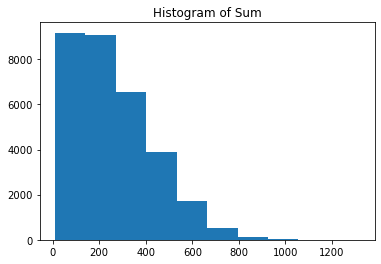

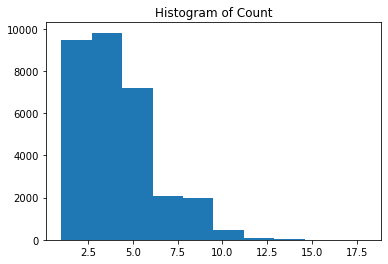

In [7]:
plt.hist(clnt_annual_aggregations["ann_txn_amt_sum"])
plt.title("Histogram of Sum")
plt.show()

plt.hist(clnt_annual_aggregations["ann_txn_amt_cnt"])
plt.title("Histogram of Count")
plt.show()

##### 3. Reset the index and reshape the table with the pivot table function to create the clnt_annual_aggregations_pivot table shown below with 40 columns 
why 40: 8 statistical properties (sum,count,...) and each one with 5 years, total 40 columns

In [8]:
clnt_annual_aggregations_pivot = clnt_annual_aggregations.pivot_table(index='customer_id',columns='YEAR')
clnt_annual_aggregations_pivot = clnt_annual_aggregations_pivot.fillna(0)

# NaN happens when clients do not shop for this particular month, replace with 0 won't effect sum and count. 

print ("clnt_annual_aggregations_pivot with 40 columns:", clnt_annual_aggregations_pivot.shape[1]==40)
clnt_annual_aggregations_pivot.head()

# clnt_annual_aggregations_pivot.isna().sum().sum()

clnt_annual_aggregations_pivot with 40 columns: True


ann_txn_amt_ave                                              \
YEAR                   2011       2012       2013       2014       2015   
customer_id                                                               
CS1112            70.666667  67.400000  70.666667  70.666667  39.000000   
CS1113            81.333333  74.800000  85.200000  56.500000  73.333333   
CS1114            85.200000  75.000000  70.400000  70.833333  79.000000   
CS1115            87.000000  67.571429  79.571429  78.250000  55.000000   
CS1116            58.750000  76.666667  59.000000  66.600000   0.000000   

            ann_txn_amt_cnt                      ... ann_txn_amt_sum         \
YEAR                   2011 2012 2013 2014 2015  ...            2011   2012   
customer_id                                      ...                          
CS1112                  3.0  5.0  3.0  3.0  1.0  ...           212.0  337.0   
CS1113                  3.0  5.0  5.0  4.0  3.0  ...           244.0  374.0   
CS1114                  5.0  2.0  5.0  6.0  1.0  ...           426.0  150.0   
CS1115                  3.0  7.0  7.0  4.0  1.0  ...           261.0  473.0   
CS1116                  4.0  3.0  1.0  5.0  0.0  ...           235.0  230.0   

                                 ann_txn_amt_var                           \
YEAR          2013   2014   2015            2011        2012         2013   
customer_id                                                                 
CS1112       212.0  212.0   39.0      485.333333  161.800000  1190.333333   
CS1113       426.0  226.0  220.0      444.333333  290.200000   171.200000   
CS1114       352.0  425.0   79.0       94.700000  968.000000   619.300000   
CS1115       557.0  313.0   55.0      225.000000  477.285714   110.952381   
CS1116        59.0  333.0    0.0      449.583333  908.333333     0.000000   

                                     
YEAR               2014        2015  
customer_id                          
CS1112       284.333333    0.000000  
CS1113       781.666667  745.333333  
CS1114       726.166667    0.000000  
CS1115       512.250000    0.000000  
CS1116       636.800000    0.000000  

[5 rows x 40 columns]

##### 4. The pivoted object you created is a MultiIndex object with hierarchical indexes. 
What are your observations regarding the number of levels and the column names?

In [9]:
# clnt_annual_aggregations_pivot.columns.nlevels 
# there are two levels 

# clnt_annual_aggregations_pivot.columns
# pivot table columns names start with level 0 and followed by level 1.

##### 5. Finally, you want to save the dataframe clnt_annual_aggregations_pivot as an .xlsx file for future use in the machine learning assignment. To do so, you want to remove the two levels in columns and create a single level with column names: 'ann txn amt ave 2011', 'ann txn amt ave 2012', etc. 
Describe what each line of code in the box does and save the output dataframe as an Excel file annual features.xlsx. 

In [10]:
# extract level 0 & 1 and store in level_0 & level_1
level_0 = clnt_annual_aggregations_pivot.columns.get_level_values(0).astype(str)
level_1 = clnt_annual_aggregations_pivot.columns.get_level_values(1).astype(str)

# create a single level with column names
clnt_annual_aggregations_pivot.columns = level_0 + '_' + level_1

# save the output dataframe as an Excel file annual_features.xlsx
clnt_annual_aggregations_pivot.to_excel("annual_features.xlsx")
# pd.read_excel("annual_features.xlsx")

clnt_annual_aggregations_pivot.head()

,ann_txn_amt_ave_2011,ann_txn_amt_ave_2012,ann_txn_amt_ave_2013,ann_txn_amt_ave_2014,ann_txn_amt_ave_2015,ann_txn_amt_cnt_2011,ann_txn_amt_cnt_2012,ann_txn_amt_cnt_2013,ann_txn_amt_cnt_2014,ann_txn_amt_cnt_2015,...,ann_txn_amt_sum_2011,ann_txn_amt_sum_2012,ann_txn_amt_sum_2013,ann_txn_amt_sum_2014,ann_txn_amt_sum_2015,ann_txn_amt_var_2011,ann_txn_amt_var_2012,ann_txn_amt_var_2013,ann_txn_amt_var_2014,ann_txn_amt_var_2015
customer_id,,,,,,,,,,,,,,,,,,,,,
CS1112,70.666667,67.400000,70.666667,70.666667,39.000000,3.0,5.0,3.0,3.0,1.0,...,212.0,337.0,212.0,212.0,39.0,485.333333,161.800000,1190.333333,284.333333,0.000000
CS1113,81.333333,74.800000,85.200000,56.500000,73.333333,3.0,5.0,5.0,4.0,3.0,...,244.0,374.0,426.0,226.0,220.0,444.333333,290.200000,171.200000,781.666667,745.333333
CS1114,85.200000,75.000000,70.400000,70.833333,79.000000,5.0,2.0,5.0,6.0,1.0,...,426.0,150.0,352.0,425.0,79.0,94.700000,968.000000,619.300000,726.166667,0.000000
CS1115,87.000000,67.571429,79.571429,78.250000,55.000000,3.0,7.0,7.0,4.0,1.0,...,261.0,473.0,557.0,313.0,55.0,225.000000,477.285714,110.952381,512.250000,0.000000
CS1116,58.750000,76.666667,59.000000,66.600000,0.000000,4.0,3.0,1.0,5.0,0.0,...,235.0,230.0,59.0,333.0,0.0,449.583333,908.333333,0.000000,636.800000,0.000000


##### 6. What are the possible disadvantages in capturing client transaction behavior with the annual features described in this section?

In [11]:
# There are too many redundant features among total 40 features.For example, we already have standard deviation,
# variance won't provide additional information. 

# I think nnual spending data in too generalized, dealing monthly/weekly data would provide more information 
# like what day the transaction happened, peak season/month for selling, etc 

### <font color='red'>1.3 Create monthly aggregations</font> 
##### 1. Create the dataframe that captures the monthly sum and count of transactions per client (name it clnt_monthly_aggregations). 

In [12]:
clnt_monthly_aggregations = txn.groupby(["customer_id","ME_DT"]).agg(
    mth_txn_amt_sum = pd.NamedAgg('tran_amount','sum'),
    mth_txn_cnt = pd.NamedAgg('tran_amount','count'))
clnt_monthly_aggregations.iloc[0:15,:]

mth_txn_amt_sum  mth_txn_cnt
customer_id ME_DT                                   
CS1112      2011-06-30               56            1
            2011-08-31               96            1
            2011-10-31               60            1
            2012-04-30               56            1
            2012-06-30               52            1
            2012-07-31               81            1
            2012-09-30               72            1
            2012-12-31               76            1
            2013-03-31              105            1
            2013-07-31               36            1
            2013-11-30               71            1
            2014-04-30               63            1
            2014-07-31               90            1
            2014-12-31               59            1
            2015-01-31               39            1

##### 2. Create a histogram of both columns you created. What are your observations? What are the most common and maximum values for each column? How do they compare with the ones in section 1.2?

For column mth_txn_amt_sum, most common value = 77, max value = 460
For column mth_txn_cnt, most common value = 1, max value = 6


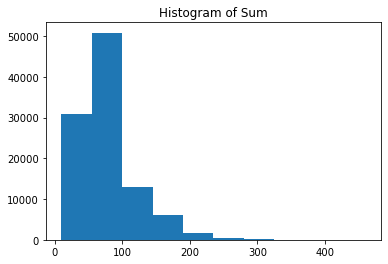

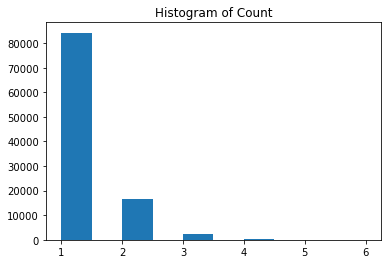

In [13]:
# most common and maximum values
common_value = list(map(lambda x: Counter(x).most_common(1)[0][0], 
                                       [clnt_monthly_aggregations["mth_txn_amt_sum"],
                                        clnt_monthly_aggregations["mth_txn_cnt"]]))

print ("For column mth_txn_amt_sum, most common value = %g, max value = %g" 
       % (common_value[0], max(clnt_monthly_aggregations["mth_txn_amt_sum"])))  

print ("For column mth_txn_cnt, most common value = %g, max value = %g" 
       % (common_value[1], max(clnt_monthly_aggregations["mth_txn_cnt"])))  

# histogram
plt.hist(clnt_monthly_aggregations["mth_txn_amt_sum"])
plt.title("Histogram of Sum")
plt.show()

plt.hist(clnt_monthly_aggregations["mth_txn_cnt"])
plt.title("Histogram of Count")
plt.show()

# The histogram output is consistent with most common and maximum values derived previously

# Both distrubutions in section 1.3 and 1.2 have right tials. 
# The frequency in 1.3 is less than 1.2 since monthly transaction is less than yearly transaction. 
# There're some bins with zero frequency in section 1.3 becauce client didn't make purchases each month. 
# But client made purchases each year, so there are no bins with zero frequency in section 1.2.

### <font color='red'>1.4 Create the base table for the rolling window features</font>  

##### 1. Create the numpy array of the unique elements in columns 'customer_id' and 'ME_DT' of the txn table.

In [14]:
# Confirm have 6,889 unique clients and 47 unique month-end-dates.
clnt_no = txn["customer_id"].unique()
print("Confirm have 6,889 unique clients:", len(txn["customer_id"].unique())==6889 )

me_dt = txn["ME_DT"].unique()
print("Confirm have 47 unique month-end-dates:", len(txn["ME_DT"].unique())== 47)

Confirm have 6,889 unique clients: True
Confirm have 47 unique month-end-dates: True


##### 2. Generate all the possible combinations of 'customer_id' and 'ME_DT'. Itertools is a Python module that iterates over data in a computationally efficient way.

In [15]:
# create an itertools.product object
base_table = product (clnt_no,me_dt)

##### 3. Convert the itertools.product object base_table into a pandas object called base_table_pd.

In [16]:
base_table_pd = pd.DataFrame.from_records(base_table)
# name the columns  
base_table_pd.columns=["CLNT_NO","ME_DT"]
base_table_pd

,CLNT_NO,ME_DT
0,CS5295,2013-02-28
1,CS5295,2015-03-31
2,CS5295,2011-11-30
3,CS5295,2013-11-30
4,CS5295,2014-03-31
...,...,...
323778,CS8077,2011-08-31
323779,CS8077,2012-09-30
323780,CS8077,2014-09-30
323781,CS8077,2014-02-28


##### 4. Validate that created the table originally wanted. 

In [17]:
# Perform first check
     
# Filter client CS1112 and confirm dates fall between the min and max month-dates identified in section 1.1.   
CS1112_end_date = base_table_pd[base_table_pd["CLNT_NO"] == "CS1112"]["ME_DT"]
print ("confirm client CS1112 shop dates fall between the min and max month-dates:", 
       sum((CS1112_end_date >= min(txn['txn_date'])) & (CS1112_end_date <= last_days.apply(max(txn['txn_date'])))) == 47)

# confirm that the snapshot of client CS1112 has 47 (month) rows
print ("confirm client CS1112 has 47 rows:", len(base_table_pd[base_table_pd["CLNT_NO"] == "CS1112"])==47)

confirm client CS1112 shop dates fall between the min and max month-dates: True
confirm client CS1112 has 47 rows: True


In [18]:
# Perform second check:
# Confirm that the base_table_pd has 323,783 rows, which is the expected value of combinations for 6,889 unique 
# clients and 47 unique month-end dates.
print ("confirm base_table_pd has 323,783 rows:", base_table_pd.shape[0] == 323783) 

confirm base_table_pd has 323,783 rows: True


### <font color='red'>1.5 Create the monthly rolling window features</font>  

##### 1. Left-join the base_table_pd with the clnt_monthly_aggregations table from section 1.3 on [CLNT_NO, ME_DT] to create the table base_clnt_ mth. 
##### Why do some rows have NaN values
The LEFT TABLE base_table_pd has 323783 rows of all combination of clients and month_end_dates, the RIGHT TABLE clnt_monthly_aggregations only has 103234 rows. LEFT JOIN join matched records from both tables. When there's no matched records, result keep records from the left table, Null for the right table.  
##### What values will you choose to impute NaN values in the sum and count columns? Perform the imputation you suggest.
NaN happens when clients do not shop for this particular month, replace with 0 won't effect statistical properties such as sum and count. 
##### Confirm that the number of rows is what you expect. What is the value?
323783
##### How are tables base_clnt_mth and clnt_monthly_aggregations different? Comment on the number of rows and the content of each table.
clnt_monthly_aggregations only has 103234 rows, it only contains the data of transaction. 
<br>
base_clnt_mth has 323783 rows, contains all data for both transaction and non-transaction (fill with 0)

In [19]:
base_clnt_mth = base_table_pd.join(clnt_monthly_aggregations, on=['CLNT_NO','ME_DT'], how='left', sort=False) 
base_clnt_mth = base_clnt_mth.fillna(0)
base_clnt_mth
print ("Confirm number of rows is 323783:", base_clnt_mth.shape[0] == 323783)

Confirm number of rows is 323783: True


##### 2. Sort the data FIrst by 'CLNT_NO' and then by 'ME_DT' in ascending order. This is necessary to create the order for rolling windows, e.g. 2011-05-31, 2011-06-30, etc.

In [20]:
base_clnt_mth = base_clnt_mth.sort_values(['CLNT_NO','ME_DT'],ascending = True)

##### 3. calculate separately the 3, 6 and 12-month rolling window features (tables: rolling_features_3M, rolling_features_6M, rolling_features_12M) for every client that calculates the aggregations 'sum', mean' and 'max' for both columns 'mth_txn_amt_sum' and 'mth_txn_cnt'.

##### How many rows appear with NaN values at the beginning of each client for 3, 6 and 12-month windows, respectively? Why do they appear?
2, 5, 11 rows respectively. Rolling method computes statistical property start at $(n+1)^{th}$ row, there's no output for the first n points. 

##### How many levels do the index and columns have? Are these MultiIndex dataframes?
There are 2 levels of index and columns, and both are MultiIndex dataframes.

In [21]:
# calculate separately the 3, 6 and 12-month rolling window features
rolling_features_3M = base_clnt_mth.groupby(['CLNT_NO']).rolling(3).agg(['max','sum','mean'])
rolling_features_6M = base_clnt_mth.groupby(['CLNT_NO']).rolling(6).agg(['max','sum','mean'])
rolling_features_12M = base_clnt_mth.groupby(['CLNT_NO']).rolling(12).agg(['max','sum','mean'])

# levels of the index and columns
print ("Index levels:",rolling_features_3M.index.nlevels)
print ("Columns levels:",rolling_features_3M.columns.nlevels)

rolling_features_3M.iloc[0:5,:]

Index levels: 2
Columns levels: 2


mth_txn_amt_sum                   mth_txn_cnt               
                           max    sum       mean         max  sum      mean
CLNT_NO                                                                    
CS1112  157064             NaN    NaN        NaN         NaN  NaN       NaN
        157058             NaN    NaN        NaN         NaN  NaN       NaN
        157044            56.0   56.0  18.666667         1.0  1.0  0.333333
        157069            96.0  152.0  50.666667         1.0  2.0  0.666667
        157060            96.0   96.0  32.000000         1.0  1.0  0.333333

In [22]:
# Rename the columns 
rolling_features_3M.columns = ['amt_sum_3M', 'amt_mean_3M', 'amt_max_3M', 'txn_cnt_sum_3M', 'txn_cnt_mean_3M', 'txn_cnt_max_3M']
rolling_features_6M.columns = ['amt_sum_6M', 'amt_mean_6M', 'amt_max_6M', 'txn_cnt_sum_6M', 'txn_cnt_mean_6M', 'txn_cnt_max_6M']
rolling_features_12M.columns = ['amt_sum_12M', 'amt_mean_12M', 'amt_max_12M', 'txn_cnt_sum_12M', 'txn_cnt_mean_12M', 'txn_cnt_max_12M']

##### 4. Merge the 4 tables: base_clnt_mth, rolling_features_3M, rolling_features_6M, rolling_features_12M in the output all_rolling_features. 

In [23]:
# combine rolling_features_3M,rolling_features_6M,rolling_features_12M
rolling_combine = pd.concat([rolling_features_3M,rolling_features_6M,rolling_features_12M],axis=1)
rolling_combine = rolling_combine.droplevel(level=1)
rolling_combine.index = range(323783)

# change index of base_clnt_mth
base_clnt_mth.index = range(323783)

# Merge tables 
all_rolling_features = pd.concat([base_clnt_mth,rolling_combine],axis=1)
all_rolling_features

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M
0,CS1112,2011-05-31,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CS1112,2011-06-30,56.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CS1112,2011-07-31,0.0,0.0,56.0,56.0,18.666667,1.0,1.0,0.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CS1112,2011-08-31,96.0,1.0,96.0,152.0,50.666667,1.0,2.0,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CS1112,2011-09-30,0.0,0.0,96.0,96.0,32.000000,1.0,1.0,0.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323778,CS9000,2014-11-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,10.166667,1.0,2.0,0.333333,35.0,97.0,8.083333,1.0,4.0,0.333333
323779,CS9000,2014-12-31,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,10.166667,1.0,2.0,0.333333,35.0,97.0,8.083333,1.0,4.0,0.333333
323780,CS9000,2015-01-31,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,5.833333,1.0,1.0,0.166667,35.0,81.0,6.750000,1.0,3.0,0.250000
323781,CS9000,2015-02-28,34.0,1.0,34.0,34.0,11.333333,1.0,1.0,0.333333,...,5.666667,1.0,1.0,0.166667,35.0,115.0,9.583333,1.0,4.0,0.333333


##### 5. Confirm that your final output all_rolling_features has 323,783 rows and 22 columns and save it as mth_rolling_features.xlsx.

In [24]:
print ("Final output all_rolling_features has 323,783 rows and 22 columns:",
       all_rolling_features.shape == (323783, 22))

# save as xlsx file
all_rolling_features.to_excel("mth_rolling_features.xlsx")
# pd.read_excel("mth_rolling_features.xlsx")

Final output all_rolling_features has 323,783 rows and 22 columns: True


### <font color='red'>1.6 Date-related features: date of the week</font>  

##### 1. Extract the day of the week from column 'txn_date' of the txn table (with Monday=0, Sunday=6).

In [25]:
txn['day_of_the_week'] = pd.DatetimeIndex(txn['txn_date']).dayofweek
txn['day_name'] = pd.DatetimeIndex(txn['txn_date']).day_name()
txn.head()

,customer_id,tran_amount,txn_date,ME_DT,YEAR,day_of_the_week,day_name
0,CS5295,35,2013-02-11,2013-02-28,2013,0,Monday
1,CS4768,39,2015-03-15,2015-03-31,2015,6,Sunday
2,CS2122,52,2013-02-26,2013-02-28,2013,1,Tuesday
3,CS1217,99,2011-11-16,2011-11-30,2011,2,Wednesday
4,CS1850,78,2013-11-20,2013-11-30,2013,2,Wednesday


##### 2. Plot the histogram that shows the count of transactions per day of the week.

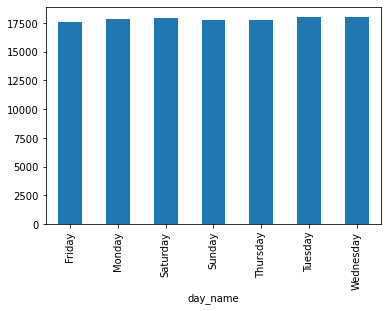

In [26]:
txn.groupby('day_name').tran_amount.count().plot.bar()
plt.show()

##### 3. Following the same logic as in section 1.2, generate the features that capture the count of transactions per client, year and day of the week. 

In [27]:
# The intermediate MultiIndex dataframe (with nlevels=3)
annual_day_of_week_counts = txn.groupby(["customer_id","day_name","YEAR"]).count()["tran_amount"]
annual_day_of_week_counts = pd.DataFrame(annual_day_of_week_counts) 
annual_day_of_week_counts.columns = ["cnt"]

# create pivot table 
annual_day_of_week_counts_pivot = annual_day_of_week_counts.pivot_table(index='customer_id',columns=["YEAR","day_name"])
# fill nan with 0 and change value to integer
annual_day_of_week_counts_pivot = annual_day_of_week_counts_pivot.fillna(0)
annual_day_of_week_counts_pivot = annual_day_of_week_counts_pivot.astype(int)
annual_day_of_week_counts_pivot

cnt                                                           \
YEAR          2011                                                     2012   
day_name    Friday Monday Saturday Sunday Thursday Tuesday Wednesday Friday   
customer_id                                                                   
CS1112           1      0        0      1        0       0         1      0   
CS1113           1      1        0      1        0       0         0      2   
CS1114           0      1        0      1        1       0         2      0   
CS1115           0      0        1      1        0       0         1      1   
CS1116           1      1        0      0        1       1         0      1   
...            ...    ...      ...    ...      ...     ...       ...    ...   
CS8996           0      1        0      0        0       1         0      0   
CS8997           0      0        0      0        1       0         1      1   
CS8998           0      0        0      0        0       1         1      2   
CS8999           0      1        1      0        0       1         0      1   
CS9000           0      0        0      2        0       0         0      1   

                             ...                                           \
YEAR                         ...     2014                     2015          
day_name    Monday Saturday  ... Thursday Tuesday Wednesday Friday Monday   
customer_id                  ...                                            
CS1112           0        1  ...        1       1         1      0      0   
CS1113           1        0  ...        0       3         0      0      2   
CS1114           0        1  ...        0       1         1      0      0   
CS1115           1        0  ...        2       0         2      0      0   
CS1116           0        0  ...        0       0         0      0      0   
...            ...      ...  ...      ...     ...       ...    ...    ...   
CS8996           0        3  ...        1       1         2      0      0   
CS8997           2        0  ...        0       0         0      0      0   
CS8998           0        0  ...        0       1         1      0      0   
CS8999           0        2  ...        0       0         2      0      0   
CS9000           0        1  ...        1       1         0      0      0   

                                                        
YEAR                                                    
day_name    Saturday Sunday Thursday Tuesday Wednesday  
customer_id                                             
CS1112             0      0        0       0         1  
CS1113             0      0        0       0         1  
CS1114             0      0        1       0         0  
CS1115             0      0        1       0         0  
CS1116             0      0        0       0         0  
...              ...    ...      ...     ...       ...  
CS8996             0      0        0       0         0  
CS8997             0      0        0       0         0  
CS8998             0      0        0       0         0  
CS8999             0      0        0       0         0  
CS9000             1      0        0       0         0  

[6889 rows x 35 columns]

In [28]:
# final pivoted output with a single index 

level_0 = annual_day_of_week_counts_pivot.columns.get_level_values(0).astype ( str)
level_1 =annual_day_of_week_counts_pivot.columns.get_level_values (1).astype ( str)
level_2 = annual_day_of_week_counts_pivot.columns.get_level_values (2).astype ( str)

annual_day_of_week_counts_pivot.columns = level_0 + '_' + level_1 + '_' + level_2
annual_day_of_week_counts_pivot 

,cnt_2011_Friday,cnt_2011_Monday,cnt_2011_Saturday,cnt_2011_Sunday,cnt_2011_Thursday,cnt_2011_Tuesday,cnt_2011_Wednesday,cnt_2012_Friday,cnt_2012_Monday,cnt_2012_Saturday,...,cnt_2014_Thursday,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday
customer_id,,,,,,,,,,,,,,,,,,,,,
CS1112,1,0,0,1,0,0,1,0,0,1,...,1,1,1,0,0,0,0,0,0,1
CS1113,1,1,0,1,0,0,0,2,1,0,...,0,3,0,0,2,0,0,0,0,1
CS1114,0,1,0,1,1,0,2,0,0,1,...,0,1,1,0,0,0,0,1,0,0
CS1115,0,0,1,1,0,0,1,1,1,0,...,2,0,2,0,0,0,0,1,0,0
CS1116,1,1,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CS8996,0,1,0,0,0,1,0,0,0,3,...,1,1,2,0,0,0,0,0,0,0
CS8997,0,0,0,0,1,0,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
CS8998,0,0,0,0,0,1,1,2,0,0,...,0,1,1,0,0,0,0,0,0,0


##### 4. Confirm output has the same number of rows as the final output in section 1.2 and save it as annual_day_of_week_counts_pivot.xlsx. 
How many features/columns did you create in this section?
35 features of combination of 5 years and 7 days each week

In [29]:
print ("confirm annual_day_of_week_counts_pivot has same number of rows as final outpyt in section 1.2:",
       annual_day_of_week_counts_pivot.shape[0] == clnt_annual_aggregations_pivot.shape[0])

print ("number of features/columns create:",annual_day_of_week_counts_pivot.shape[1])

# save output as xlsx file
annual_day_of_week_counts_pivot.to_excel("annual_day_of_week_counts_pivot.xlsx")

confirm annual_day_of_week_counts_pivot has same number of rows as final outpyt in section 1.2: True
number of features/columns create: 35


##### 5. Similarly, generate the features that capture the count of transactions per client, month-end-date and day of the week. In contrast with the annual pivot table in the previous step, here you want to create the pivot with ['customer id', 'ME DT'] as index to obtain the following output dataframe.

In [30]:
annual_last_day_counts = txn.groupby(["customer_id" ,"ME_DT","day_name"]).count()["tran_amount"]
annual_last_day_counts = pd.DataFrame(annual_last_day_counts) 
annual_last_day_counts.columns = ["cnt"]
annual_last_day_counts

# create pivot table 
annual_last_day_counts_pivot = annual_last_day_counts.pivot_table(index=['customer_id','ME_DT'],columns=["day_name"])
# fill nan with 0 and change value to integer
annual_last_day_counts_pivot = annual_last_day_counts_pivot.fillna(0)
annual_last_day_counts_pivot = annual_last_day_counts_pivot.astype(int)

# final pivoted output with a single index 
level_0 = annual_last_day_counts_pivot.columns.get_level_values(0).astype (str)
level_1 =annual_last_day_counts_pivot.columns.get_level_values (1).astype (str)

annual_last_day_counts_pivot.columns = level_0 + '_' + level_1 
annual_last_day_counts_pivot.head()

cnt_Friday  cnt_Monday  cnt_Saturday  cnt_Sunday  \
customer_id ME_DT                                                          
CS1112      2011-06-30           0           0             0           0   
            2011-08-31           1           0             0           0   
            2011-10-31           0           0             0           1   
            2012-04-30           0           0             0           1   
            2012-06-30           0           0             0           1   

                        cnt_Thursday  cnt_Tuesday  cnt_Wednesday  
customer_id ME_DT                                                 
CS1112      2011-06-30             0            0              1  
            2011-08-31             0            0              0  
            2011-10-31             0            0              0  
            2012-04-30             0            0              0  
            2012-06-30             0            0              0

##### 6. Join with base_table_pd as you did in section 1.5 and impute with your choice of value for NaN. Save the final output as mth_day_counts.xlsx.

In [31]:
mth_day_counts = base_table_pd.join(annual_last_day_counts_pivot, on=['CLNT_NO','ME_DT'], how='left', sort=False) 
mth_day_counts = mth_day_counts.fillna(0)

# Save the final output as excel file
mth_day_counts.to_excel("mth_day_counts.xlsx")

### <font color='red'>1.7 Date-related features: days since last transaction</font>  # 

##### 1. Since you want to calculate the "days since last transaction", you want to capture the last transaction in a month for every client. Use the appropriate groupby to create the table last_monthly_purchase that captures the last 'txn_date' (aggfunc=max) for every client and month.

In [32]:
last_monthly_purchase = txn.groupby(['customer_id','ME_DT']).agg(
    last_montnly_purchase = pd.NamedAgg('txn_date','max')) 

##### 2. Join base table pd with last monthly purchase as you did in section 1.5 and created object last_monthly_purchase_base.  What values will you use to impute the NaT ( "Not a Timestamp") values here?  

In [33]:
last_monthly_purchase_base = base_table_pd.join(last_monthly_purchase, on=['CLNT_NO','ME_DT'], how='left', sort=False) 

# Sort the data First by 'CLNT_NO' and then by 'ME_DT' in ascending order.
last_monthly_purchase_base = last_monthly_purchase_base.sort_values(['CLNT_NO','ME_DT'],ascending = True)
last_monthly_purchase_base
# fill na in next part

,CLNT_NO,ME_DT,last_montnly_purchase
157064,CS1112,2011-05-31,NaT
157058,CS1112,2011-06-30,2011-06-15
157044,CS1112,2011-07-31,NaT
157069,CS1112,2011-08-31,2011-08-19
157060,CS1112,2011-09-30,NaT
...,...,...,...
295140,CS9000,2014-11-30,NaT
295126,CS9000,2014-12-31,NaT
295119,CS9000,2015-01-31,NaT
295136,CS9000,2015-02-28,2015-02-28


##### 3. Forward-fill the NaT values use the apply and a lambda function with the forward-fill function ffill(), applied on object last_monthly_purchase_base grouped by CLNT_NO. 

The forward-fill on the grouped by CLNT NO object is expected to leave NaT values for the first months of every client until they purchase something.

In [34]:
last_monthly_purchase_base = last_monthly_purchase_base.groupby('CLNT_NO').apply(lambda x: x.ffill())
last_monthly_purchase_base.iloc[92:98,:]

,CLNT_NO,ME_DT,last_montnly_purchase
160011,CS1113,2015-02-28,2015-02-09
159989,CS1113,2015-03-31,2015-02-09
101134,CS1114,2011-05-31,NaT
101128,CS1114,2011-06-30,NaT
101114,CS1114,2011-07-31,2011-07-14
101139,CS1114,2011-08-31,2011-08-24


##### 4. Subtract the two date columns and convert the output to .dt.days to calculate the column 'days_since_last_txn'.

In [35]:
last_monthly_purchase_base['days_since_last_txn'] = (last_monthly_purchase_base.ME_DT - last_monthly_purchase_base.last_montnly_purchase).dt.days
last_monthly_purchase_base.head()

,CLNT_NO,ME_DT,last_montnly_purchase,days_since_last_txn
157064,CS1112,2011-05-31,NaT,NaN
157058,CS1112,2011-06-30,2011-06-15,15.0
157044,CS1112,2011-07-31,2011-06-15,46.0
157069,CS1112,2011-08-31,2011-08-19,12.0
157060,CS1112,2011-09-30,2011-08-19,42.0


##### 5. Plot a histogram of the 'days_since_last_txn'. Based on the values you observe in the histogram, impute the remaining NaN values  (i.e. for the initial months before a client makes a purchase). 
Save the columns ['CLNT_NO', 'ME_DT', 'days_since_last_txn'] as days_since_last_txn.xlsx.

In [36]:
##### last_monthly_purchase_base.days_since_last_txn.hist(bins=30)
plt.show()

last_monthly_purchase_base
# # fill nan with median rather than mean, since mean is largely influenced by outliers.
# med_value = last_monthly_purchase_base.days_since_last_txn.median()
# last_monthly_purchase_base.days_since_last_txn = last_monthly_purchase_base.days_since_last_txn.fillna(med_value)

,CLNT_NO,ME_DT,last_montnly_purchase,days_since_last_txn
157064,CS1112,2011-05-31,NaT,NaN
157058,CS1112,2011-06-30,2011-06-15,15.0
157044,CS1112,2011-07-31,2011-06-15,46.0
157069,CS1112,2011-08-31,2011-08-19,12.0
157060,CS1112,2011-09-30,2011-08-19,42.0
...,...,...,...,...
295140,CS9000,2014-11-30,2014-08-24,98.0
295126,CS9000,2014-12-31,2014-08-24,129.0
295119,CS9000,2015-01-31,2014-08-24,160.0
295136,CS9000,2015-02-28,2015-02-28,0.0


In [37]:
# fill nan with -10 (required by prof)
last_monthly_purchase_base.days_since_last_txn = last_monthly_purchase_base.days_since_last_txn.fillna(-10)

In [38]:
# Save the columns ['CLNT_NO', 'ME_DT', 'days_since_last_txn'] as to excel file
last_monthly_purchase_base[['CLNT_NO', 'ME_DT', 'days_since_last_txn']].to_excel("days_since_last_txn.xlsx")
# pd.read_excel("days_since_last_txn.xlsx")